# Melanoma Classification

This notebook aims to develop a CV pipeline for classification of images of nevus, seborrheic_keratosis or malignant melanoma. For this, we will use Convolutional Neural Networks and data from the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a).



In [35]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

This will be done using torchvision DataLoaders and transforms.

The pipeline for training examples includes data augmentation. Since the image is not supposed to have directionality, it can be flipped and rotated in the full range.

In [122]:
data_folder = "data/"
norm_mean = [0.5, 0.5, 0.5]
norm_std = [0.25, 0.25, 0.25]

train_transforms = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])
])

data = {
    "train": datasets.ImageFolder(data_folder+"train", transform=train_transforms),
    "valid": datasets.ImageFolder(data_folder+"valid", transform=test_transforms),
    "test":  datasets.ImageFolder(data_folder+"test",  transform=test_transforms),
}

loaders = {
    "train": torch.utils.data.DataLoader(data["train"], shuffle=True,  batch_size=32),
    "valid": torch.utils.data.DataLoader(data["valid"], shuffle=False, batch_size=64),
    "test":  torch.utils.data.DataLoader(data["test"],  shuffle=False, batch_size=64),
}

classes = data["train"].classes

## Visualizing the data

We will display batches of (augmented) training data and validation data.

In [123]:
def show_one_batch(loader):
    data, labels = next(iter(loader))
    data = (data.numpy() * np.array(norm_std).reshape((1,3,1,1)) + 
            np.array(norm_mean).reshape((1,3,1,1))).clip(0,1)
    bs = len(labels)
    
    n_rows = (bs//10+1)
    fig = plt.figure(figsize=(25, 2.5*n_rows))
    for i, (image, label) in enumerate(zip(data, labels)):
        ax = fig.add_subplot(n_rows, 10, i+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(classes[labels[i]])

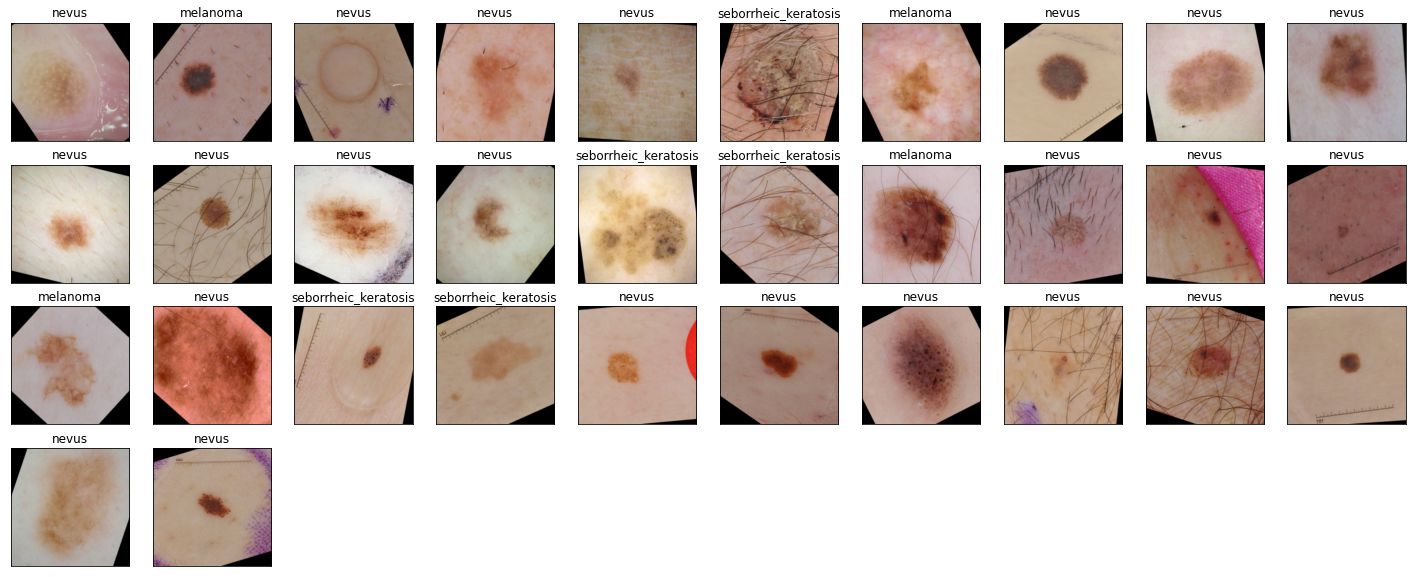

In [124]:
show_one_batch(loaders["train"])

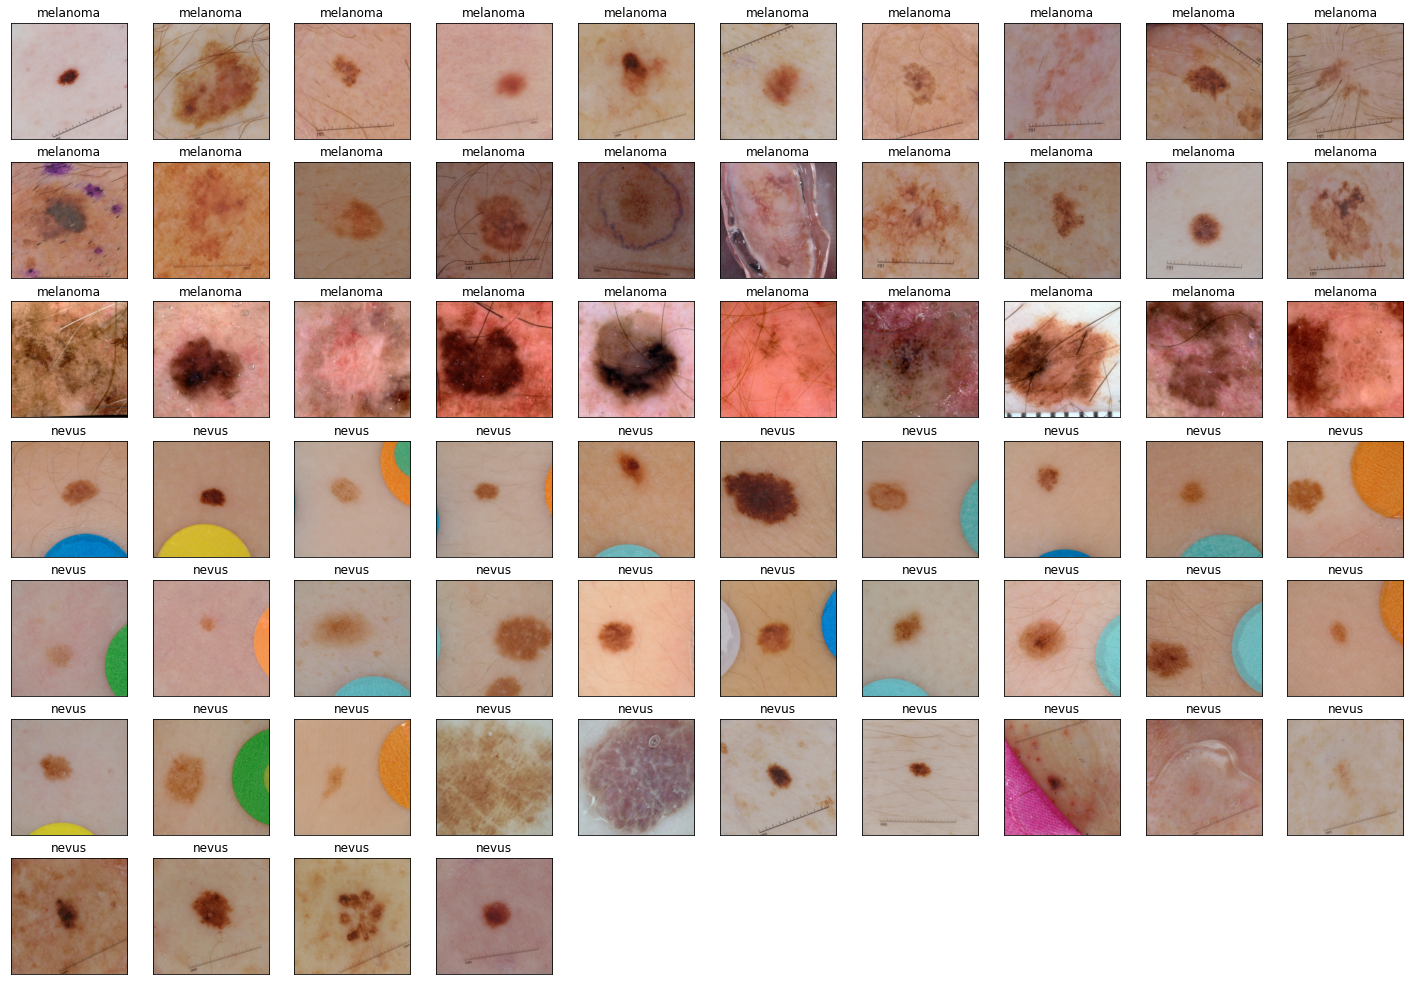

In [125]:
show_one_batch(loaders["valid"])

Care might be needed with the images that include circles for scale.

We should also be aware of how mane examples there are for each category in the train and validation sets.

In [135]:
def dataset_value_count(dataset):
    classes = dataset.classes
    counts = np.bincount(dataset.targets)
    return {classes[i]: counts[i] for i in range(len(classes))}

In [136]:
dataset_value_count(data["train"])

{'melanoma': 374, 'nevus': 1372, 'seborrheic_keratosis': 254}

In [137]:
dataset_value_count(data["valid"])

{'melanoma': 30, 'nevus': 78, 'seborrheic_keratosis': 42}

The classes are not proportionally distributed among the train and validation datasets, and there are many more examples of nevus than of melanoma or seborrheic keratosis.